# Analyze A/B Test Results 

This project  will apply  probability  principles on the the Dataset  then  applying  an A/B testing  to see if the  users  will  prefer the  old page  or the new  one. Then  we will apply  a simple regression model to check the results of the AB test.

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  the  goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.



<a id='probability'></a>
## Part I - Probability



In [1]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

In [3]:
# reading the  csv  file
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


### From the  documentary of the Data set, Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>

In [4]:
#counting the number of the rows
df.count()

user_id         294478
timestamp       294478
group           294478
landing_page    294478
converted       294478
dtype: int64

In [56]:
# counting the number of the unique users 
df.user_id.nunique()

290584

In [57]:
#calculating the proportion of the  unique users  who converted
df[df['converted']==1]['user_id'].nunique()/df['user_id'].nunique()

0.12104245244060237

In [58]:
df['converted'].mean()

0.11965919355605512

In [59]:
# calculating the  number of times when treatment and  new page  don't line up together
treat_not_new=df.query('group=="treatment" & landing_page!="new_page"')['user_id'].count()
new_not_treat=df.query('group!="treatment" & landing_page=="new_page"')['user_id'].count()
print('total number ',new_not_treat+treat_not_new)

total number  3893


In [60]:
#checking if  we have null  values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

## Note: 
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  




In [5]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df.drop(df[(df.group =="treatment") & (df.landing_page != "new_page")].index,inplace=True)
df2=df.drop(df[(df.group =="control") & (df.landing_page != "old_page")].index)


In [6]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

**a.** How many unique **user_id**s are in **df2**?

In [7]:
df2.user_id.nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [16]:
df2[df2.duplicated(['user_id'])]['user_id']

Series([], Name: user_id, dtype: int64)

**c.** Display the rows for the duplicate **user_id**

In [17]:
df2[df2.duplicated(['user_id'],keep=False)]

,user_id,timestamp,group,landing_page,converted


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [18]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2.drop(1899,inplace=True)


KeyError: '[1899] not found in axis'

In [ ]:
# Check again if the row with a duplicate user_id is deleted or not
df2.duplicated().sum()

## Note:

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>

 The probability   computed represents the overall "converted" success rate in the population and you may call it $p_{population}$.



In [22]:
p_population=df2.converted.mean()
p_population

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [23]:
converted_control=df2[df2['group']=='control']['converted'].mean()
converted_control

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [24]:
converted_treat=df2[df2['group']=='treatment']['converted'].mean()
converted_treat

0.11880806551510564

>**Tip**: The probabilities  computed in the points (b). and (c). above can also be treated as conversion rate. 
 I will calculate the actual difference  (`obs_diff`) between the conversion rates for the two groups. I will need that later.  

In [25]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff=converted_control-converted_treat
obs_diff

0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [26]:
# calculating the  proportion of the  users  who received the  new page,  almost  half of the users
len(df2[df2.landing_page=='new_page'])/len(df2.landing_page)

0.5000619442226688

first of all, the  test   seems  to be  well  designed  to have  half of the users in the  control  group and the  other half is  in the treatment  one. Since the  conversion  rates to use the treatment  page  for both  groups are almost  equal (0.1203863045004612 and 0.11880806551510564),  there is not  enough evidence  that the  treatment page led to  more conversions.

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, I could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do I have  to  stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long  should I  run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


For now,  we  need to make the decision just based on all the data provided.  

> Recall that I  just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page.

If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be our null and alternative hypotheses (**$H_0$** and **$H_1$**)?  




    Null hypothesis: the conversion rate of the old page is greater  than or  equal the conversion rate of the  new             one.(P_old >= Pnew)

    Alternative : the conversion rate of the  old page is less than the conversion rate of the  new one(P_old < Pnew)



###  Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, I  will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 





**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [27]:
#since  the assumption of the null nypothesis states that theere is no difference between the  the old  and  new pages and 
#they are  equal to P_population, we will use the  whole dataset to calculate p_new
p_new=df2['converted'].mean()
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [28]:
#since  the assumption of the null nypothesis states that theere is no difference between the  the old  and  new pages and 
#they are  equal to P_population, we will use the  whole dataset to calculate p_old
p_old=df2['converted'].mean()
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>
*Hint*: The treatment group users are shown the new page.

In [29]:
n_new=len(df2[df2.landing_page=='new_page'])
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [30]:
n_old=len(df2[df2.landing_page=='old_page'])
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>
we will Use `numpy.random.choice()` method to randomly generate $n_{new}$ number of values. <br>
 and Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [31]:
# Simulate a Sample for the treatment Group
new_page_sample = np.random.choice(2, size=n_new ,p=[p_new,1 - p_new])
new_page_sample.mean()



0.8805312779574702

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [32]:
# Simulate a Sample for the control Group
old_page_sample = np.random.choice(2, size=n_old ,p=[p_old,1 - p_old])
old_page_sample.mean()


0.8802056803006733

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [33]:
diff=new_page_sample.mean()-old_page_sample.mean()
diff

0.00032559765679696095


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [34]:
# Sampling distribution  for  10000 times and calculating the  differences
p_diffs = []
bsample_new_means=[]
bsample_old_means=[]
for _ in range(10000):
    bsample_new = np.random.choice(2, size=n_new ,p=[p_new,1 - p_new])
    bsample_old = np.random.choice(2, size=n_old ,p=[p_old,1 - p_old])
    bsample_new_means.append(bsample_new.mean())
    bsample_old_means.append(bsample_old.mean())
    p_diffs.append(bsample_new.mean() - bsample_old.mean())

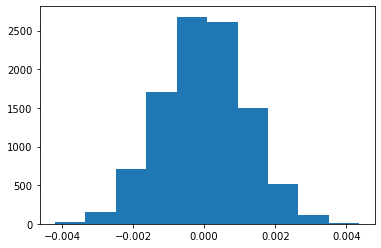

In [35]:
#plotting the histogram for the  sample distribution of  mean differences
p_diffs_array=np.array(p_diffs)
plt.hist(p_diffs_array);

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [36]:
#calculating the  actual difference between the  conversion rate  for users showed  old page and  users  shown  new page
new_conv=df2[df2.landing_page=='new_page']['converted'].mean()
old_conv=df2[df2.landing_page=='old_page']['converted'].mean()
actual_diff=new_conv-old_conv




In [37]:
#calculating the p value 
(p_diffs>actual_diff).mean()

TypeError: '>' not supported between instances of 'list' and 'float'

 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

#### Answer:
 this value is  called the p_value.
 the value of  p  value is  larger than the 0.05  significance level  which tells us that we can't reject  the null hypothesis and the 
  conversion rate of the  old page is larger or  equal  to the  conversion rate of the old page.



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

 we will  calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [ ]:
n_new = df2.landing_page.value_counts()
n_new

In [ ]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query('landing_page == "old_page" & converted == "1"').count()[0]
# number of conversions with the new_page
convert_new = df2.query('landing_page == "new_page" & converted == "1"').count()[0]


# number of individuals who were shown the old_page
n_old =df2.landing_page.value_counts()[1]

# number of individuals who received new_page
n_new = df2.landing_page.value_counts()[0]

convert_old,convert_new,n_old,n_new



---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. 
>Hint:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 


In other words, we determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. A "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.



Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

---

>**Tip**: You don't have to dive deeper into z-test for this exercise. **Try having an overview of what does z-score signify in general.** 

In [38]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old],value=None, alternative='larger', prop_var=False)
print(z_score, p_value)


NameError: name 'convert_new' is not defined

**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>

>**Tip**: Notice whether the p-value is similar to the one computed earlier. Accordingly, can you reject/fail to reject the null hypothesis? It is important to correctly interpret the test statistic and p-value.

#### Answer:
the z  value  is less than the  z  value of  0.05 significance factor (-1.310<1.645) so  we  fail to  reject the null hypothesis  and  the conversion rate of the old age is larger than the  conversion rate of the old page
Further,  the p value  here is  different  from what we  calculated before, this  is  due  to  the fact that  last  time we assumed that p_new=p_old,  which is the  conversion rate is the same  for both pages  and this is not  true as  we  failed to  reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, we will see that the result we achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should we be performing in this case?

 since we have categorical  response variable, we will choose the  logistic regression
 

**b.** The goal is to use **statsmodels** library to fit the regression model  we  specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, we first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [39]:
# setting the intercept and  the  dummy variables for the group column
df2['intercept']=1
df2[['ab_page','treatment']] = pd.get_dummies(df2['group'])
# dropping the treatment column, no more useful
df2 = df2.drop('treatment', axis=1)


In [40]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1


**c.** Using **statsmodels** to instantiate our regression model on the two columns you created in part (b). above, then  we will fit the model to predict whether or not an individual converts. 


In [41]:
#   creating and fitting the  logistic regession model and getting the summary of the values
log_model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_model.fit()
results.summary2() 


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2021-11-10 21:39 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -2.0038    0.0081  -247.1457  0.0000  -2.0197  -1.9879
ab_page       0.0150    0.0114     1.3109  0.1899  -0.0074   0.0374
==================================================================

"""

In [42]:
#finding the exponential  of the  coefficients, since it is a  logistic regression and  values  need to be  handled by the sigmoid   function
np.exp(0.0150)

1.015113064615719

**d.** Providing  summary of our model below, and using  it as necessary to answer the following questions.

the results of the regression  summary states  that there  is achance of 1.015  of conversions  more than  the  non-conversions, with all other  variables constant

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

**Hints**: 
- What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**? 
- You may comment on if these hypothesis (Part II vs. Part III) are one-sided or two-sided. 
- You may also compare the current p-value with the Type I error rate (0.05).


 the p-value  of the ab_page is  equal  to 0.1889 which  is larger than the  0.05 sig. coefficient  so we  fail to reject the null hypothesis.
 with this  regression model, we have a  2  tailed hypotheses which  wasn't the case in part  2  wen we  chose a  1 tailed hypotheses. So the  value of the p  value  here is  different  from the  previously calculated one, further, previously, we  assumed that the p_new=p_old

**f.** Now,  considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into our regression model.  Are there any disadvantages to adding additional terms into your regression model?

 culture  and being in a specific region in the world may  affect the conversion rate  from one page to another, so adding  countries   of users may   be useful
  adding more  factors  to the   regression model may affect the confidence intervals,  and adding  too many  factors may decrease the accuracy  of the model

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1.  we  will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 
>**Hint:** Use `pandas.get_dummies()` to create dummy variables. **You will utilize two columns for the three dummy variables.** 

 Provide the statistical output as well as a written response to answer this question.

In [43]:
# Read the countries.csv
dff = pd.read_csv('countries.csv')
dff.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [44]:
# Join with the df2 dataframe

df3 = df2.join(dff.set_index('user_id'), on='user_id')
df3.head()



,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,US


In [45]:
# create necessary dummy variables  out of the  country categorical  column
df3[['CA','UK', 'US']] = pd.get_dummies(df3['country'])
# drop the country column since this is not  needed anymore
df3 = df3.drop('country', axis=1)
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,0,1


In [46]:
#creating  new  columns in the data frame to calculate if  users  used the new aoge in these countries
df3['US_ab'] = df3['US'] * df3['ab_page']
df3['UK_ab'] = df3['UK'] * df3['ab_page']
df3['CA_ab'] = df3['CA'] * df3['ab_page']

In [47]:
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,US_ab,UK_ab,CA_ab
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,0,1,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,0,1,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,0,0,1,0,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,0,0,1,0,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,0,1,1,0,0


**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 

>**Tip**: Conclusions should include both statistical reasoning, and practical reasoning for the situation. 

>**Hints**: 
- Look at all of p-values in the summary, and compare against the Type I error rate (0.05). 
- Can you reject/fail to reject the null hypotheses (regression model)?
- Comment on the effect of page and country to predict the conversion.


In [48]:
#fitting a model  to find the effect of the countries on the conversion rates
log_mod1 = sm.Logit(df3['converted'], df3[['intercept','ab_page', 'UK', 'CA']])
results1=log_mod1.fit()
results1.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2021-11-10 21:42 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -2.0042    0.0089  -224.5600  0.0000  -2.0217  -1.9867
ab_page       0.0149    0.0114     1.3069  0.1912  -0.0075   0.0374
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
==================================================================

"""

In [49]:
np.exp(0.0149),np.exp(0.0099),np.exp(0.0099)

(1.0150115583846535, 1.0099491671175422, 1.0099491671175422)

If we sat an  hypotheses  for this model, we will have a  2 sided hupotheses,The Null: is that  the conversion rate is the same  for the countries. the Alternative: is that the conversion rate is changing  due  to the country effect
when  checking the  effect of the countries on the conversion rate  we  found that being in the UK or  Canada will have 1.0099491671175422, 1.0099491671175422  times   conversion rate  compared to the intercept(The US)  which approximately the same effect, so we can say  that  we failed  to  reject the null  HYP. Further, based on the  p  values (0.1912,0.4573,0.1295) respictively, all of them are not significant  and they  support  my claim  not to reject the  NULL.  Thus,   reaching  to  that  the  countries has no effect on the conversion rate

In [50]:
# Fit another model based on the newly created  columns of the multiplication of the ab page and each  country 


log_mod = sm.Logit(df3['converted'], df3[['intercept','UK','CA','ab_page', 'UK_ab', 'CA_ab']])
results = log_mod.fit()
results.summary2()



Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2021-11-10 21:42 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -2.0070    0.0097  -207.0454  0.0000  -2.0260  -1.9880
UK            0.0257    0.0188     1.3634  0.1728  -0.0112   0.0625
CA           -0.0644    0.0384    -1.6788  0.0932  -0.1396   0.0108
ab_page       0.0206    0.0137     1.5052  0.1323  -0.0062   0.0473
UK_ab        -0.0314    0.0266    -1.1807  0.2377  -0.0835   0.0207
CA_ab         0.0469    0.0538     0.8718  0.3833  -0.0585   0.1523
==================================================================

"""

In [51]:
np.exp(-0.0314),np.exp(0.0469)

(0.9690878603945013, 1.048017202119183)

## summary:
by checking  the   exponentials of the  coefficients  from the  model summary, we  find that the Uk and Canada has(0.96908786039450134, 1.0480172021191829) times compared  to the US  respictevely, which  is almost the same. Further, by looking  at the p  values. we can find that they are  much larger than  the significance factor (0.2377,0.3833) respictively and  we  find that  the interaction  with the pages is not significantly  different   in these  countries  and  we fail to reject the  null hyp. that there is no change in the conversion rate based on the change in  country.

conclusion: based on the values  we  got  from the  A/B testing, the z  test  and the  logistic regression, we can't reject the  null hypothesis and the  company  should   use the old page instead of the new one.

In [100]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0